In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ejercicio 11 del Capitulo 2 del Gelman:

Supongamos mediciones independientes $y_{1},y_{2},...,y_{5}$ que siguen una distribucion de Cauchy con centro desconocido $\theta$ y escala conocida $1$.

$p(y_{i}|\theta) \propto \frac{1}{1 + (y_{i} − \theta)^{2}}$

Asumimos por simplicidad que el prior es una distribucion uniforme en [0,100]. Si observamos ($y_{1},..., y_{5}$) = (43, 44, 45, 46.5, 47.5):

1.   Calcule la distribucion posterior no normalizada $p(y|\theta)p(\theta)$ en una grilla de puntos $\theta = 0, \frac{1}{m},\frac{2}{m},...,100$ para algun entero $m$ grande. Utilizando esta aproximacion numerica, calcule y grafique la posterior normalizada $p(\theta|y)$ como funcion de $\theta$.
2.   Samplee 1000 muestras de $\theta$ la posterior y haga un histograma de las muestras.
3.   Use las 1000 muestras de $\theta$ para obtener 1000 muestras de $y_{6}$ utilizando la posterior predictiva, y haga un histograma.




# Resolucion

## a)

Inicialicemos las mediciones

In [2]:
y=np.asarray([43,44,45,46.5,47.5])

Y los valores posibles de $\theta$

In [3]:
theta_vals=np.linspace(0.0,100.0,3000)
print(theta_vals[0],theta_vals[-1])

0.0 100.0


Para cada $\theta$, la verosimilitud se calcula como:

$p(y|\theta)=\prod_{i=1}^{5}p(y_{i}|\theta)$

Numericamente, es mas estable calcular el logaritmo de la probabilidad:

$\text{ln }p(y|\theta)=\sum_{i=1}^{5}\text{ln }p(y_{i}|\theta)$

In [4]:
from scipy.stats import cauchy

In [5]:
cauchy?

In [6]:
print("Prob para theta=0:", np.prod(cauchy(loc=theta_vals[0]).pdf(y)))
print("Prob para theta=0:", np.exp(np.sum(cauchy(loc=theta_vals[0]).logpdf(y))))

Prob para theta=0: 9.217719162911935e-20
Prob para theta=0: 9.217719162911966e-20


Vamos paso a paso:

In [7]:
print(y.shape)
print(cauchy(loc=theta_vals[0]).pdf(y).shape)
print(y)
print(cauchy(loc=theta_vals[0]).pdf(y))

(5,)
(5,)
[43.  44.  45.  46.5 47.5]
[0.00017206 0.00016433 0.00015711 0.00014714 0.00014102]


Pero no tenemos un unico valor de $\theta$! Tenemos varios.

In [8]:
verosimilitud=np.asarray([np.exp(np.sum(cauchy(loc=theta).logpdf(y))) for theta in theta_vals])
verosimilitud.shape

(3000,)

In [9]:
verosimilitud_aux=np.asarray([cauchy(loc=theta_vals).logpdf(y_val) for y_val in y])
print(verosimilitud_aux.shape)
verosimilitud=np.exp(np.sum(verosimilitud_aux,axis=0))
print(verosimilitud.shape)

(5, 3000)
(3000,)


In [10]:
prior=1.0/(theta_vals[-1]-theta_vals[0])*np.ones(len(theta_vals))

Text(0.5, 0, '$\\theta$')

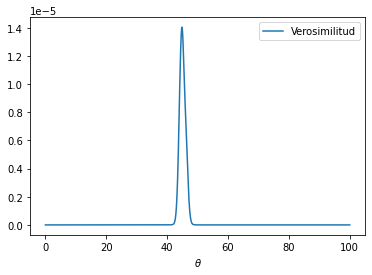

In [11]:
#plt.plot(theta_vals,prior,label='Prior')
plt.plot(theta_vals,verosimilitud,label='Verosimilitud')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

Y cuanto vale $p(y|\theta)p(\theta)$?

In [12]:
print(prior.shape)
print(verosimilitud.shape)
print((prior*verosimilitud).shape)

(3000,)
(3000,)
(3000,)


In [13]:
posterior_no_normalizado=prior*verosimilitud

Verificamos (una vez) que esta bien

In [14]:
np.allclose(posterior_no_normalizado,np.asarray([prior[i]*verosimilitud[i] for i in range(len(verosimilitud))]))

True

Text(0.5, 0, '$\\theta$')

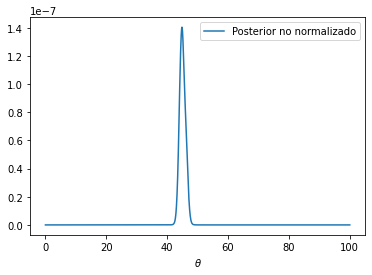

In [15]:
plt.plot(theta_vals,posterior_no_normalizado,label='Posterior no normalizado')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

Obviamente aca es la verosimilitud

Y la evidencia? Bueno, podemos calcularla numericamente

$$p(y)=\int d\theta p(y|\theta)p(\theta)\approx \sum_{j=1}^{m}\Delta_{j}p(y|\theta_{j})p(\theta_{j})$$


In [16]:
evidencia=np.sum(posterior_no_normalizado)*(theta_vals[1]-theta_vals[0])
print(evidencia)
posterior=posterior_no_normalizado/evidencia
print(np.sum(posterior)*(theta_vals[1]-theta_vals[0]))

3.418359031121251e-07
0.9999999999999999


Text(0.5, 0, '$\\theta$')

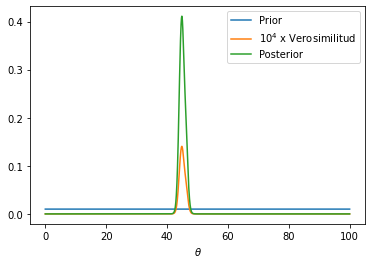

In [17]:
plt.plot(theta_vals,prior,label='Prior')
plt.plot(theta_vals,10000*verosimilitud,label='$10^{4}$ x Verosimilitud')
plt.plot(theta_vals,posterior,label='Posterior')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

## b)

Como sampleamos una vez que tenemos la posterior numerica?

In [18]:
theta_samples=np.random.choice(theta_vals, p=posterior*(theta_vals[1]-theta_vals[0]), size=1000)

Text(0.5, 0, '$\\theta$')

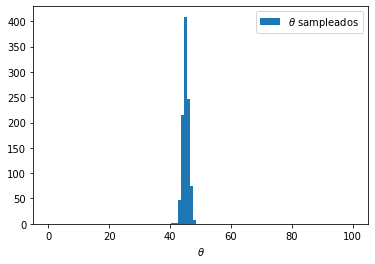

In [19]:
#bins=10
bins=np.linspace(0.0,100.0,100)
plt.hist(theta_samples,bins=bins,label=r'$\theta$ sampleados')
#plt.plot(theta_vals,len(theta_samples)*posterior,label='$N_{\t{eventos}}$ x Posterior')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

## c)

La posterior predictiva es la probabilidad de una nueva medicion $y_{6}$ dadas todas las anteriores:

$p(y_{6}|y_{1},...,y_{5})$

Para hacer esto, una opcion muy comun es plantear la posterior predictiva como una marginalización de la distribución conjunta condicional $p(y_6, \theta | \mathbf{y})$ y usar la regla del producto:

$$p(y_{6}|y_{1},...,y_{5})=\int d\theta p(y_{6},\theta|y_{1},...,y_{5})= \int d\theta p(y_{6}|\theta)p(\theta|y_{1},...,y_{5})$$

Donde asumimos que $y_{6}$ e $(y_{1},...,y_{5})$ son condicionalmente independientes dado $\theta$.

Esta integral podria hacerse numericamente de la misma manera que hicimos antes. Hacemos una grilla en $\theta$ y aproximamos la funcion para cada valor de $y_{6}$ usando esa grilla. Sin embargo, Gelman nos sugiere que aprovechemos el sampleo del interior anterior. 

Unba manera de aprovechar el sampleo es que lo podemos utilizar para aproximar la integral mucho mas eficientemente que utilizando una grilla uniforme de puntos en $\theta$. Utilizando lo que se conoce como Importance Sampling

$$\int d\theta f(\theta)\approx\frac{1}{N_{\text{sampleos}}}\sum_{n=1}^{N_{\text{sampleos}}}\frac{f(\theta_{n})}{p(\theta_{n})}$$

donde los puntos fueron sampleados de acuerdo a $p(\theta_{i})$. En nuestro, caso, el denominador se simplifica con una expresion del numerador y tenemos

$$\int d\theta p(y_{6}|\theta)p(\theta|y_{1},...,y_{5})\approx\frac{1}{N_{\text{sampleos}}}\sum_{n=1}^{N_{\text{sampleos}}}p(y_{6}|\theta_{n})$$


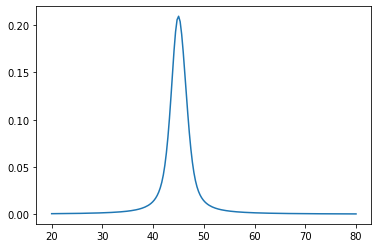

In [20]:
y6 = np.linspace(20, 80, 200)
# Calcula la likelihood para cada sample de la posterior y para cada valor de y6
A = cauchy(loc=theta_samples[np.newaxis, :]).pdf(y6[:, np.newaxis])
# Promedia a lo largo del eje correspondiente.
plt.plot(y6, A.mean(axis=1))

Y sampleamos, tal como hicimos antes

In [24]:
y_samples=np.random.choice(y6, p=A.mean(axis=1)/np.sum(A.mean(axis=1)), size=1000)

Text(0.5, 0, '$y_{6}$')

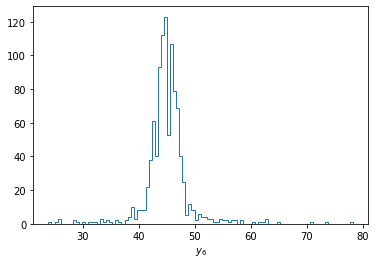

In [25]:
plt.hist(y_samples,bins=bins,histtype='step')
#plt.plot(y6, A.mean(axis=1))
plt.xlabel(r'$y_{6}$')

Sin embargo, Gelman nos sugiere que aprovechemos todavia mas el sampleo de la posterior. Dado los N $\theta_{n} \sim p(\theta|y)$, podemos hacer lo siguiente: 
Si sampleamos $y_{n} \sim p(y|\theta_{n})$, tenemos N sampleos de la conjunta $p(y_{6}, \theta|y_{1},...,y_{5})$.  Si despues marginalizamos sobre $\theta$, vamos a tener datos que siguen $p(y_{6}|y_{1},...,y_{5})$. Como marginalizamos? Una manera es haciendo histogramas en $y$ sin importar los valores de $\theta$.

In [26]:
y_samples_bis=np.asarray([cauchy(loc=theta).rvs() for theta in theta_samples])

Text(0.5, 0, '$y_{6}$')

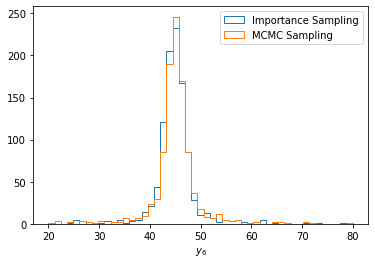

In [31]:
#bins=100
bins=np.linspace(20, 80, 50)
plt.hist(y_samples,bins=bins,histtype='step',label='Importance Sampling')
plt.hist(y_samples_bis,bins=bins,histtype='step',label='MCMC Sampling')
#plt.plot(y6, A.mean(axis=1))
plt.legend(loc='upper right')
plt.xlabel(r'$y_{6}$')

En lo importante, dan muy parecidos los metodos. Sin embargo...

In [33]:
print(min(y_samples),max(y_samples))
print(min(y_samples_bis),max(y_samples_bis))

23.91959798994975 78.19095477386935
-53.926075323801435 351.63827900223725


## Item extra

Jueguen con otros priors. Que pasa si tenemos un prior uniforme entre [0, 20]? Y si nuestro prior es $\mathcal{N}(50,1^{2})$?